In [240]:
# imports libraries
import pickle						# import/export lists
import re 							# regular expression
import pandas as pd					# dataframes
import numpy as np					# numerical computation
import matplotlib.pyplot as plt		# plot graphics

In [241]:
# opens raw data
with open ('df_profile', 'rb') as fp:
    df_profile = pickle.load(fp)

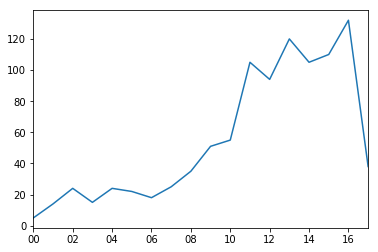

In [243]:
# examines when users first joined
entry_year = df_profile.loc[df_profile.join_year != 'NA', 'join_year']
entry = entry_year.value_counts().sort_index()
entry.plot()

plt.show()

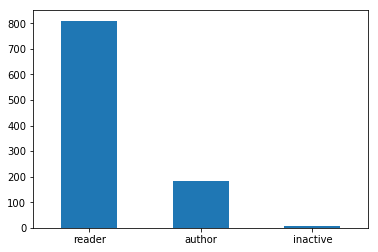

In [244]:
# examines status of users
status = df_profile['status'].value_counts()
status.plot.bar()
plt.xticks(rotation=0)

plt.show()

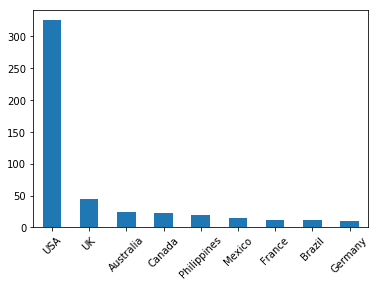

In [245]:
# examines distribution of top 10 countries
country = df_profile['country'].value_counts()[1:10]
country.plot.bar()
plt.xticks(rotation=45)

plt.show()

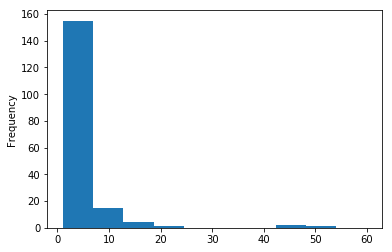

In [255]:
# examines distribution of stories written
st = df_profile.loc[df_profile.status != 'inactive', '#st']
st.plot.hist(range = [1, 60])

plt.show()

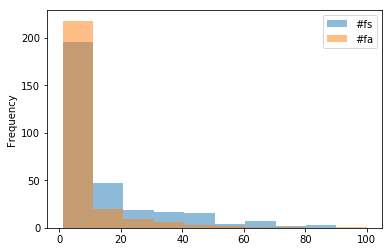

In [259]:
# examines distribution of favorited
fav = df_profile.loc[df_profile.status != 'inactive', ['#fs', '#fa']]
fav.plot.hist(alpha = 0.5, range = [1, 100])

plt.show()